# Employee Attrition Prediction  
## Second Notebook: Data Transformation and Clustering

This notebook focuses on transforming the previously prepared datasets and performing a clustering project to identify distinct employee types based on attendance patterns and work behavior. The goal is to uncover behavioral archetypes that summarize engagement, workload, volatility, and absence trends over time. These clusters will later be reintegrated into the dataset as structured features for the subsequent classification project, improving predictive insights on attrition risk.  

**Author:** J-F Jutras  
**Date:** January 2026  
**Dataset:** HR Analytics Case Study — Kaggle


## 2.1-Data Loading and Overview

In [1]:
import pandas as pd
import pickle
import sys

##Clone the public GitHub repository "jfj-utils" into the current Kaggle working directory.
#This downloads all files and folders from the repo so they can be used in the notebook.
!rm -rf /kaggle/working/jfj-utils
!git clone https://github.com/jfjutras07/jfj-utils.git

#Add the cloned repository to the Python path so Python can import modules from it
sys.path.append("/kaggle/working/jfj-utils")

#Load dataset
dataset_filename = "/kaggle/input/clusteringdataset/centralized_employee_dataset.pkl"

with open(dataset_filename, "rb") as f:
    df = pickle.load(f)

print(f"Dataset loaded successfully: {df.shape} rows x columns")

Cloning into 'jfj-utils'...
remote: Enumerating objects: 3435, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 3435 (delta 172), reused 99 (delta 99), pack-reused 3240 (from 4)
Receiving objects: 100% (3435/3435), 1.14 MiB | 16.00 MiB/s, done.
Resolving deltas: 100% (2263/2263), done.
Dataset loaded successfully: (719112, 43) rows x columns


In [2]:
df.head()

,EmployeeID,Date,Month,Week,Weekday,InTime,OutTime,ArrivalHour,DepartureHour,WorkHours,...,WeeklyLongDayCount,WeeklyArrivalStd,DaysWorked_monthly,MonthlyWorkHours,MonthlyDailyAvg,MonthlyVsPeerAvg,MonthlyAbsences,MonthlyShortDays,MonthlyLongDays,MonthlyArrivalStd
0,1,2015-01-02,1,1,Friday,2015-01-02 09:43:45,2015-01-02 16:56:15,9.716667,16.933333,7.208333,...,0,NaN,18,130.835556,7.268642,-0.201191,1,2,0,0.236634
1,1,2015-01-05,1,2,Monday,2015-01-05 10:08:48,2015-01-05 17:20:11,10.133333,17.333333,7.189722,...,0,0.239037,18,130.835556,7.268642,-0.201191,1,2,0,0.236634
2,1,2015-01-06,1,2,Tuesday,2015-01-06 09:54:26,2015-01-06 17:19:05,9.900000,17.316667,7.410833,...,0,0.239037,18,130.835556,7.268642,-0.201191,1,2,0,0.236634
3,1,2015-01-07,1,2,Wednesday,2015-01-07 09:34:31,2015-01-07 16:34:55,9.566667,16.566667,7.006667,...,0,0.239037,18,130.835556,7.268642,-0.201191,1,2,0,0.236634
4,1,2015-01-08,1,2,Thursday,2015-01-08 09:51:09,2015-01-08 17:08:32,9.850000,17.133333,7.289722,...,0,0.239037,18,130.835556,7.268642,-0.201191,1,2,0,0.236634


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719112 entries, 0 to 719111
Data columns (total 43 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   EmployeeID             719112 non-null  int64         
 1   Date                   719112 non-null  datetime64[ns]
 2   Month                  719112 non-null  int32         
 3   Week                   719112 non-null  int64         
 4   Weekday                719112 non-null  object        
 5   InTime                 681371 non-null  datetime64[ns]
 6   OutTime                681371 non-null  datetime64[ns]
 7   ArrivalHour            681371 non-null  float64       
 8   DepartureHour          681371 non-null  float64       
 9   WorkHours              681371 non-null  float64       
 10  WorkDelta              681371 non-null  float64       
 11  DailyOvertime          719112 non-null  float64       
 12  DailyDeficit           719112 non-null  floa

## 2.2-Data Refining and Cleaning

**Handling missing values**

In [4]:
#Handling absences before aggregation
#Fill NaNs with 0 to ensure the mean calculation accounts for absences
df['WorkHours'] = df['WorkHours'].fillna(0)

#Special case: WorkDelta 
#A missing day is a 100% deficit relative to the expected 8h workday
df['WorkDelta'] = df['WorkDelta'].fillna(-8)

**Feature Selection**

In [5]:
#Feature Reconstruction & Strategic Selection

#Reconstructing 'Combined_Instability' which was missing from the export.
df_dep_std = df.groupby('EmployeeID')['DepartureHour'].std().reset_index(name='Dep_Std')
df_arr_std = df.groupby('EmployeeID')['WeeklyArrivalStd'].mean().reset_index(name='Arr_Std')

df_instab = pd.merge(df_arr_std, df_dep_std, on='EmployeeID')
df_instab['Combined_Instability'] = (df_instab['Arr_Std'] + df_instab['Dep_Std']) / 2

#Merging back the reconstructed feature
df = df.merge(df_instab[['EmployeeID', 'Combined_Instability']], on='EmployeeID', how='left')

#Refined Column Selection
keep_columns = [
    'EmployeeID', 
    'WorkHours',              
    'WorkDelta',              
    'Absent',                 
    'ShortDay',               
    'LongDay',                
    'DaysWorked',             
    'WeeklyEngagementScore',
    'Volatility_Group',
    'Combined_Instability',   
]

#Final dataframe
df = df[keep_columns].copy()

#Ordinal encode Volatility_Group before the correlation analysis
df['Vol_Score'] = df['Volatility_Group'].cat.codes + 1

#Drop columns
cols_to_drop = ['Volatility_Group']
df = df.drop(columns=cols_to_drop)

**Correlation Analysis**

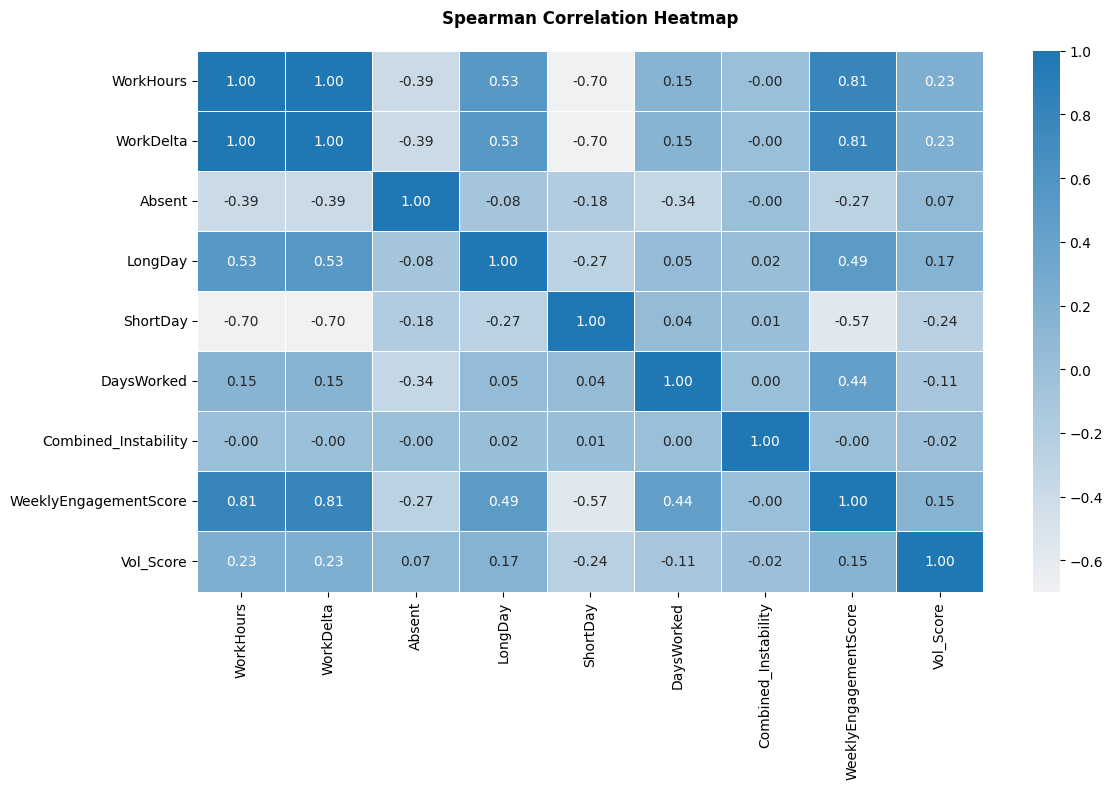

In [6]:
from visualization.explore_continuous import plot_correlation_heatmap

numeric_cols = ['WorkHours', 'WorkDelta', 'Absent','LongDay', 'ShortDay',
                'DaysWorked','Combined_Instability', 'WeeklyEngagementScore',
                'Vol_Score']

plot_correlation_heatmap(df, numeric_cols)

In [7]:
#Columns to drop
cols_to_drop = ['WorkDelta', 'LongDay', 'ShortDay', 'WeeklyEngagementScore', 'Absent']
df = df.drop(columns=cols_to_drop)

We removed WorkDelta, LongDay, ShortDay, WeeklyEngagementScore, and Absent due to high redundancy with WorkHours and DaysWorked. These columns did not provide additional information and could bias the clustering. Despite this, the three key behavioral dimensions are preserved: Workload via WorkHours, Volatility via DaysWorked and Vol_Score, and Instability via Combined_Instability. The final dataset is therefore compact and retains all essential signals for meaningful clustering.

**Type Conversion**

In [8]:
#Type Conversion
#Optimize Floats and Integers (Downcasting)
df['WorkHours'] = df['WorkHours'].astype('float32')
df['Combined_Instability'] = df['Combined_Instability'].astype('float32')
df['DaysWorked'] = df['DaysWorked'].astype('int16')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719112 entries, 0 to 719111
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   EmployeeID            719112 non-null  int64  
 1   WorkHours             719112 non-null  float32
 2   DaysWorked            719112 non-null  int16  
 3   Combined_Instability  719112 non-null  float32
 4   Vol_Score             719112 non-null  int8   
dtypes: float32(2), int16(1), int64(1), int8(1)
memory usage: 13.0 MB
None


**Data Aggregation**

In [9]:
#High-Fidelity Aggregation by Employee
#Define the specific logic for each behavioral pillar
agg_logic = {
    'WorkHours': 'sum',               #Total annual work volume
    'DaysWorked': 'sum',              #Total actual presence (activation days)
    'Combined_Instability': 'mean',   #Overall schedule reliability/volatility
    'Vol_Score' : 'first'
}

#Execute the aggregation
df_final = df.groupby('EmployeeID').agg(agg_logic).reset_index()

#Display the first few profiles
df_final.head()

,EmployeeID,WorkHours,DaysWorked,Combined_Instability,Vol_Score
0,1,1710.686890,1114,0.303168,4
1,2,1821.676636,1137,0.348542,2
2,3,1697.204102,1164,0.323129,1
3,4,1690.514404,1131,0.332915,3
4,5,1961.512817,1179,0.330097,1


**Data Scaling**

In [10]:
#Detect outliers
from data_preprocessing.outliers import detect_outliers_iqr
final_numeric_cols = ['WorkHours', 'DaysWorked', 'Combined_Instability', 'Vol_Score']
detect_outliers_iqr(df_final, ['WorkHours', 'DaysWorked', 'Combined_Instability'])

{'WorkHours': 146,
 'DaysWorked': 0,
 'Combined_Instability': 29,
 'Total_outliers': 175}

After aggregating the data at the employee level, the number of detected outliers is low and remains within acceptable bounds for clustering. These outliers carry meaningful signal related to workload intensity, engagement imbalance and schedule instability. 

As a result, no observations are removed; instead, a RobustScaler is used to mitigate the influence of extreme values while preserving their informational value. The dataset is therefore clean, stable, and fully suitable for behavioral clustering.

In [11]:
from data_preprocessing.scaling import robust_scaler
df_scaled, myscaler = robust_scaler(df_final[final_numeric_cols], test_df = None)
print(df_scaled)

--- RobustScaler Summary ---
Scaled: 4 features | Outlier-resistant logic applied
-----------------------------------
      WorkHours  DaysWorked  Combined_Instability  Vol_Score
0     -0.015689   -0.475676             -1.694144   1.000000
1      0.312572    0.021622              0.814823  -0.333333
2     -0.055566    0.605405             -0.590420  -1.000000
3     -0.075351   -0.108108             -0.049249   0.333333
4      0.726149    0.929730             -0.205087  -1.000000
...         ...         ...                   ...        ...
2883  -0.768400   -0.886486              0.474407  -0.333333
2884   0.692402    0.821622             -0.550433  -1.000000
2885  -0.069252    0.194595             -1.518507  -0.333333
2886   0.189996   -0.475676              0.763419   1.000000
2887  -0.279657   -0.454054             -0.079213   0.333333

[2888 rows x 4 columns]


**Final Check**

In [12]:
from eda.premodeling_check import premodeling_clustering_check
print(premodeling_clustering_check(df_scaled, corr_threshold = 0.7))

#Missing values
No missing values detected.

#Feature types
All features are numeric (Optimal for distance calculations).

#Scale & Magnitude check
Feature scales appear relatively consistent.

#Outliers
Outliers can distort cluster centroids (Total: 175):
  1. WorkHours: 146 points
  2. Combined_Instability: 29 points

#Feature Redundancy (|r| ≥ 0.70)
No redundant features detected.

#Final assessment
Data is ready for clustering, but review the issues above. Clustering is highly sensitive to Scaling, Outliers, and Redundant Features.


Before performing clustering, we identified a few outliers in WorkHours (146 out of 2888 observations) and Combined_Instability (29 points). While methods like K-means are sensitive to these extreme values, we chose to retain them because, from a business perspective, these high performers provide meaningful insights. To mitigate their impact on distances and cluster centroids, we applied a RobustScaler, which reduces the influence of outliers while preserving their informational value.

## 2.3-Clustering Modeling

Multiple clustering algorithms are evaluated to identify behavioral employee archetypes based on aggregated workload, engagement, volatility, and instability indicators. Given the nature of the data (low-dimensional, continuous, and behaviorally smooth), cluster separation is expected to be moderate rather than sharply defined. As a result, the evaluation focuses not only on quantitative metrics but also on model assumptions, stability, and interpretability.

In [13]:
from modeling.clustering_models import (
    agglomerative_clustering,
    birch_clustering,
    dbscan_clustering,
    gaussian_mixture_clustering,
    kmeans_clustering
)

#Configuration
K_target = 3
models_results = {}

#Execution of available models with optimization
models_results['KMeans'] = kmeans_clustering(df_scaled, final_numeric_cols, k=K_target, optimize=True)
models_results['Agglomerative'] = agglomerative_clustering(df_scaled, final_numeric_cols, k=K_target, optimize=True)
models_results['GMM'] = gaussian_mixture_clustering(df_scaled, final_numeric_cols, k=K_target, optimize=True)
models_results['BIRCH'] = birch_clustering(df_scaled, final_numeric_cols, k=K_target, optimize=True)
models_results['DBSCAN'] = dbscan_clustering(df_scaled, final_numeric_cols, optimize=True)


--- KMeans Clustering Summary ---
Clusters: 3 | Optimized: True
-----------------------------------
--- Agglomerative Clustering Summary ---
Optimal Clusters: 3 | Optimized: True
-----------------------------------
--- GMM Clustering Summary ---
Components: 7 | Optimized: True
-----------------------------------
--- BIRCH Clustering Summary ---
Clusters: 6 | Optimized: True
-----------------------------------
--- DBSCAN Clustering Summary ---
Eps: 0.5 | Min Samples: 10 | Optimized: True
-----------------------------------



--- Clustering Performance Check ---
Model                     : KMeans Final
Number of Clusters         : 3
Silhouette Score           : 0.2942  (Goal: -> 1.0)
Calinski-Harabasz Index    : 1162.72 (Goal: High)
Davies-Bouldin Index       : 1.2192  (Goal: -> 0.0)
---------------------------------------------
Status: ACCEPTABLE. Moderate structure detected; some overlap likely.
---------------------------------------------


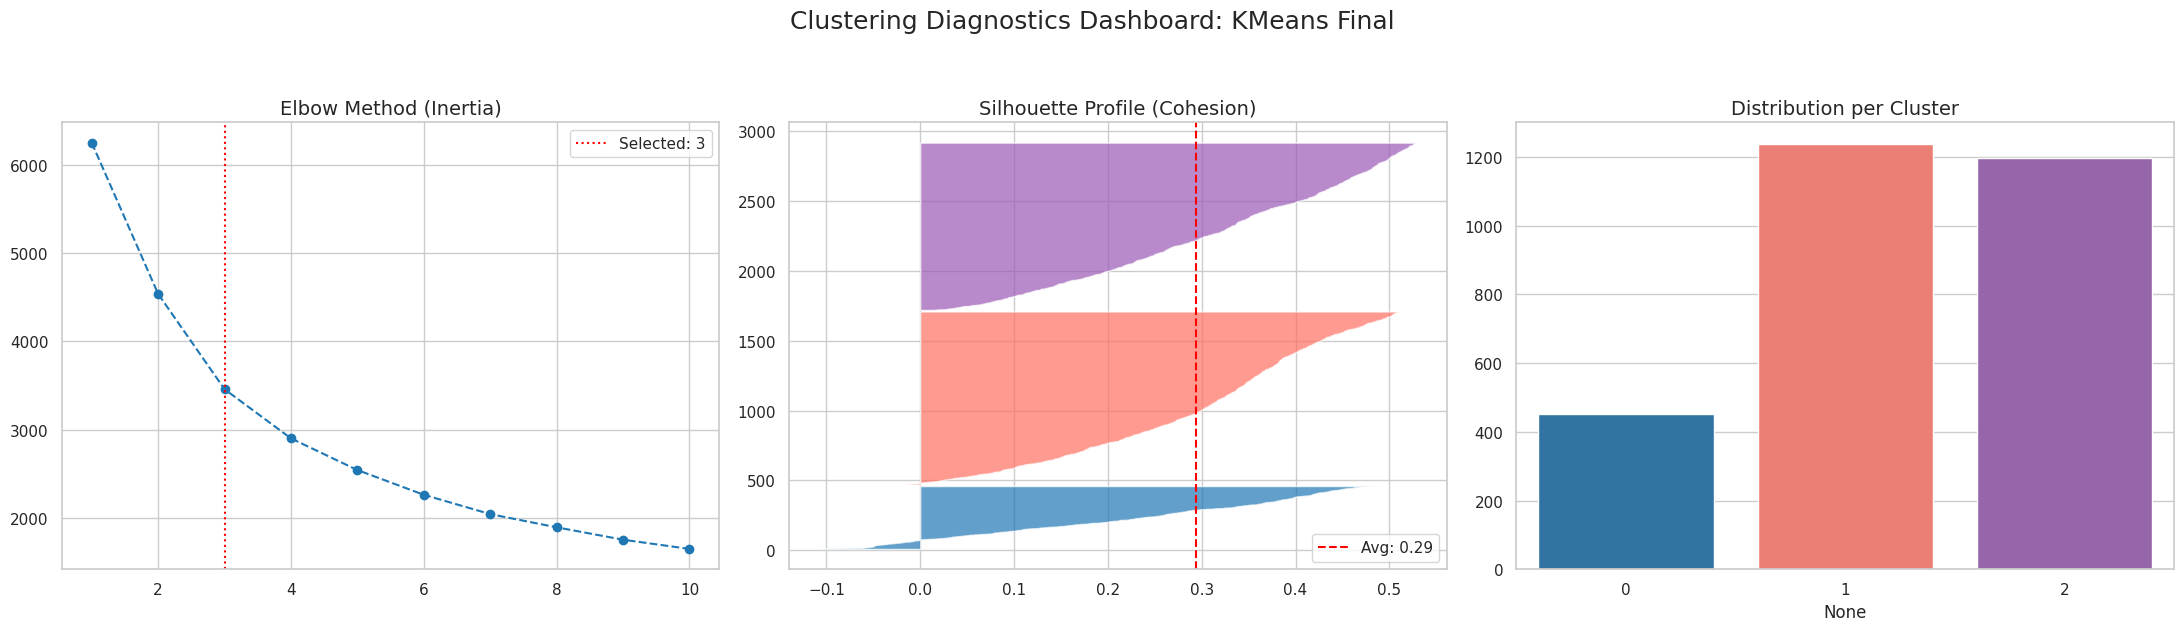


--- Clustering Performance Check ---
Model                     : Agglomerative Final
Number of Clusters         : 3
Silhouette Score           : 0.2446  (Goal: -> 1.0)
Calinski-Harabasz Index    : 913.90 (Goal: High)
Davies-Bouldin Index       : 1.3605  (Goal: -> 0.0)
---------------------------------------------
Status: WEAK. Poorly defined clusters; high risk of overlap.
---------------------------------------------


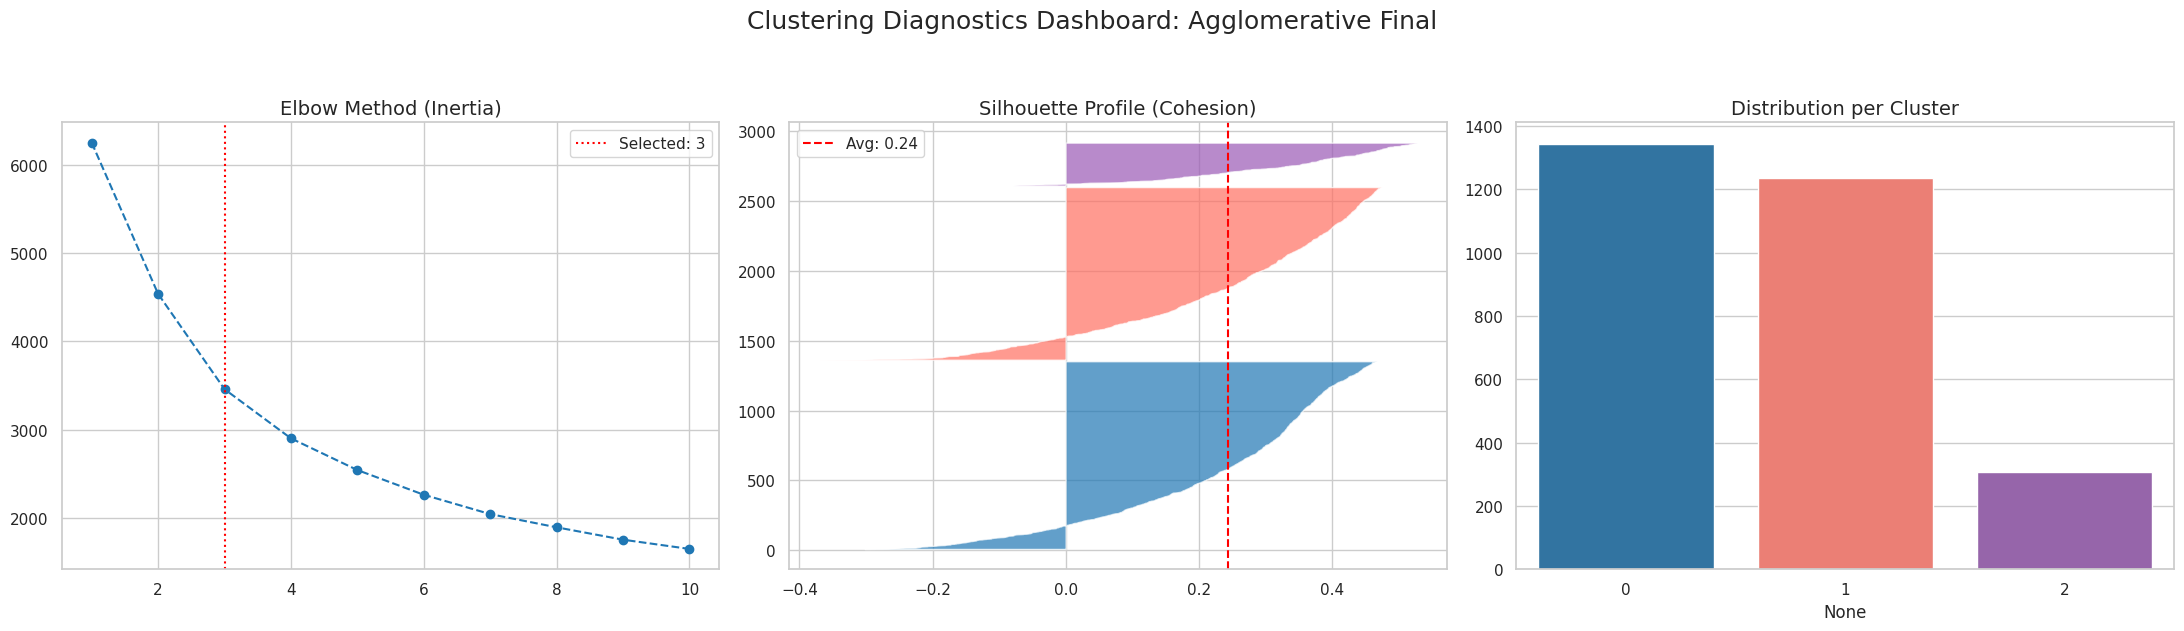


--- Clustering Performance Check ---
Model                     : GMM Final
Number of Clusters         : 7
Silhouette Score           : 0.0847  (Goal: -> 1.0)
Calinski-Harabasz Index    : 431.05 (Goal: High)
Davies-Bouldin Index       : 2.0779  (Goal: -> 0.0)
---------------------------------------------
Status: WEAK. Poorly defined clusters; high risk of overlap.
---------------------------------------------


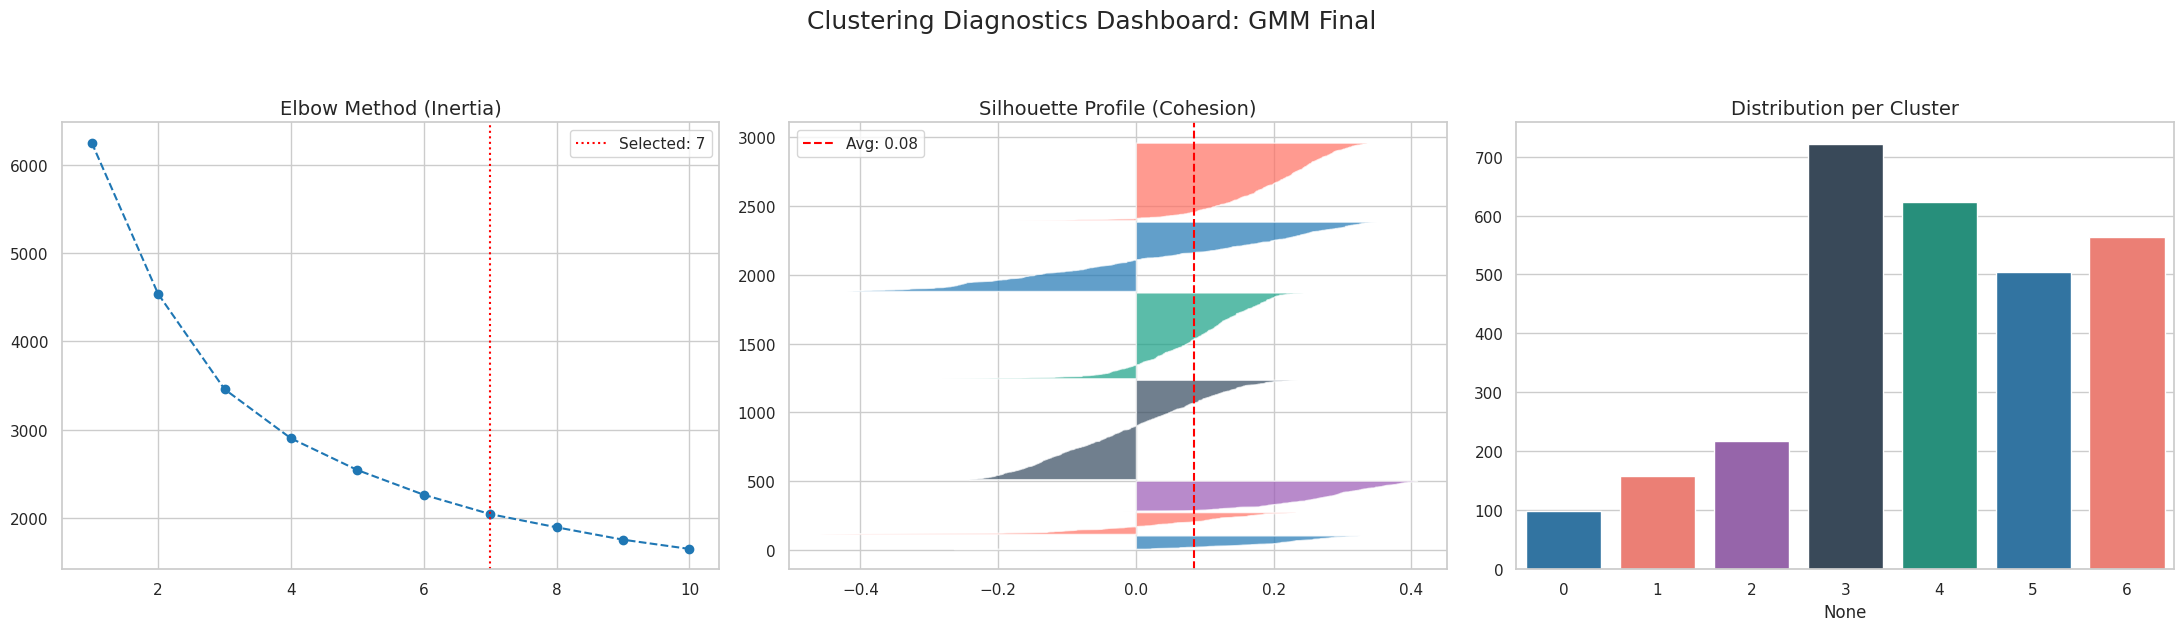


--- Clustering Performance Check ---
Model                     : BIRCH Final
Number of Clusters         : 6
Silhouette Score           : 0.1757  (Goal: -> 1.0)
Calinski-Harabasz Index    : 593.92 (Goal: High)
Davies-Bouldin Index       : 1.4488  (Goal: -> 0.0)
---------------------------------------------
Status: WEAK. Poorly defined clusters; high risk of overlap.
---------------------------------------------


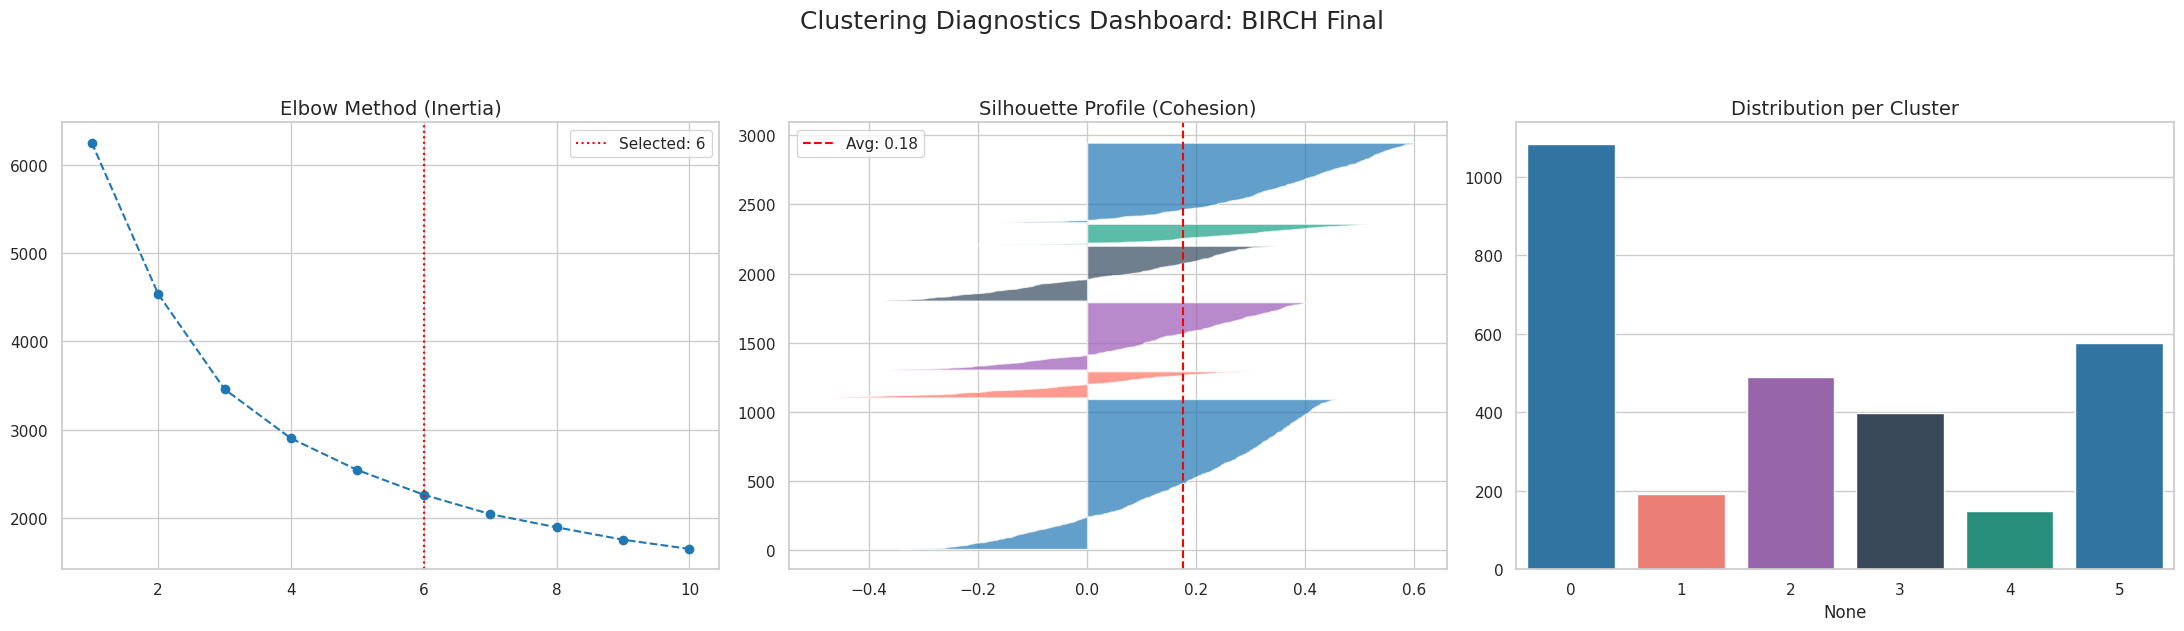


--- Clustering Performance Check ---
Model                     : DBSCAN Final
Number of Clusters         : 4
Silhouette Score           : 0.1370  (Goal: -> 1.0)
Calinski-Harabasz Index    : 597.88 (Goal: High)
Davies-Bouldin Index       : 2.3661  (Goal: -> 0.0)
---------------------------------------------
Status: WEAK. Poorly defined clusters; high risk of overlap.
---------------------------------------------


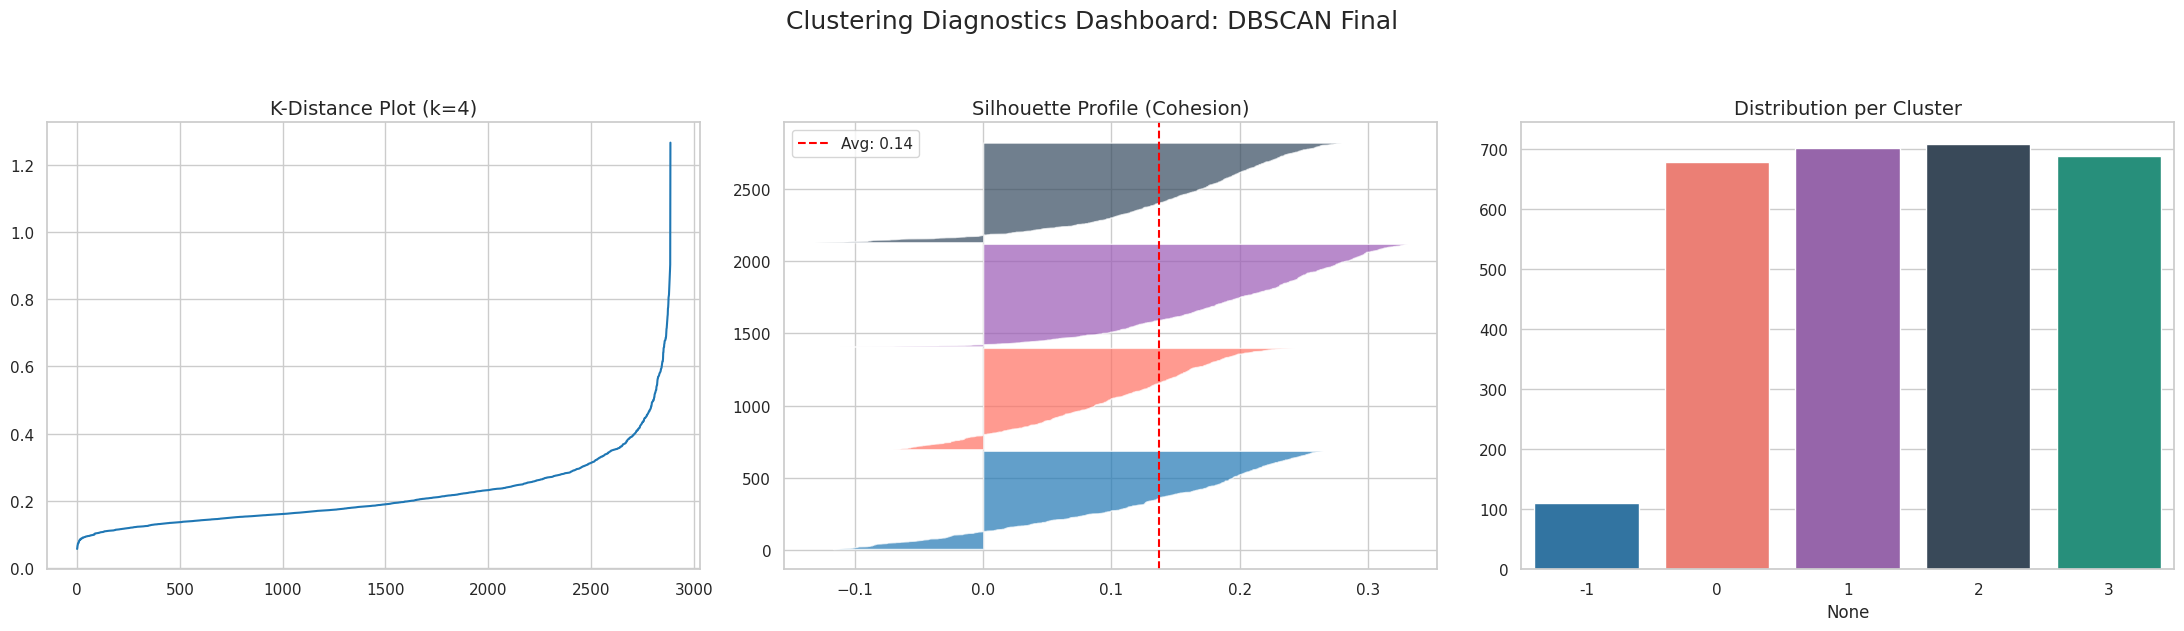

In [14]:
from visualization.explore_clusters import plot_cluster_diagnostics

#Loop through all models and plot diagnostics
for name, model in models_results.items():
    #Extract labels depending on the model type
    if hasattr(model.named_steps['model'], 'labels_'):  
        labels = model.named_steps['model'].labels_
    else:  #DBSCAN or GMM
        labels = model.named_steps['model'].fit_predict(df_scaled[final_numeric_cols])
    
    #Plot diagnostics for the current model
    plot_cluster_diagnostics(df_scaled[final_numeric_cols], labels, model_name=f"{name} Final")


K-Means with three clusters provides the most robust structure for this HR dataset. While GMM, BIRCH, and DBSCAN either over-fragment the data or struggle to identify meaningful groupings, resulting in weak Silhouette scores, K-Means achieves the best overall performance, with the highest Silhouette Score and the most favorable Davies-Bouldin Index.

Despite the moderate overlap inherent to continuous behavioral data, the three-cluster K-Means solution offers the best balance between statistical cohesion and business interpretability, making it a reliable and stable foundation for feature engineering in downstream attrition prediction models.

## 2.4-Model Validation

To ensure the identified clusters are stable and reliable, we perform a validation of the K-Means model. This step assesses the consistency of clusters across random initializations and data subsamples, verifying that the detected behavioral profiles reflect genuine patterns rather than random artifacts.

### Random Initialization and Subsampling Stability

In [15]:
from modeling.model_stability import check_clustering_model_stability

print(">>> Evaluating Stability: KMeans")
stability_scores = check_clustering_model_stability(
    model=models_results['KMeans'],
    df=df_scaled,
    predictors=final_numeric_cols
)

>>> Evaluating Stability: KMeans

--- Clustering Algorithmic Stability Check ---
Model Class              : KMeans
Seeds Evaluated           : [0, 21, 42, 84]
Subsample Fraction        : 0.8
--------------------------------------------------
Random Initialization Stability (ARI):
  ARI(seed 0 vs 21) = 1.000
  ARI(seed 0 vs 42) = 1.000
  ARI(seed 0 vs 84) = 1.000
  Mean ARI (seeds)        = 1.000
--------------------------------------------------
Subsampling Stability (ARI):
  ARI(subsample run 1) = 0.893
  ARI(subsample run 2) = 0.619
  ARI(subsample run 3) = 0.623
  Mean ARI (subsampling)  = 0.712
--------------------------------------------------
Status: HIGHLY STABLE. Cluster structure is robust.
--------------------------------------------------


The stability analysis confirms the robustness of the three-cluster K-Means solution. The model shows perfect consistency across random initializations, with a mean ARI of 1.000, indicating fully deterministic convergence and no sensitivity to seed selection.

Subsampling tests also support the reliability of the cluster structure, with a mean ARI of 0.712. Despite expected variability in behavioral data, this demonstrates that the clusters capture stable, population-level patterns rather than noise, making them suitable as reliable features for downstream attrition prediction models.

### ANOVA

**Distribution Analysis**

In [16]:
#Validation DataFrame (returning to the original (non-scaled) data for statistical tests)
validation_df = df[final_numeric_cols]

#Aggregation
validation_df = df.groupby('EmployeeID').agg({
    'WorkHours': 'sum',
    'DaysWorked': 'sum',
    'Combined_Instability': 'mean',
    'Vol_Score': 'first'
}).reset_index()

#Quick check
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2888 entries, 0 to 2887
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   EmployeeID            2888 non-null   int64  
 1   WorkHours             2888 non-null   float32
 2   DaysWorked            2888 non-null   int16  
 3   Combined_Instability  2888 non-null   float32
 4   Vol_Score             2888 non-null   int8   
dtypes: float32(2), int16(1), int64(1), int8(1)
memory usage: 53.7 KB


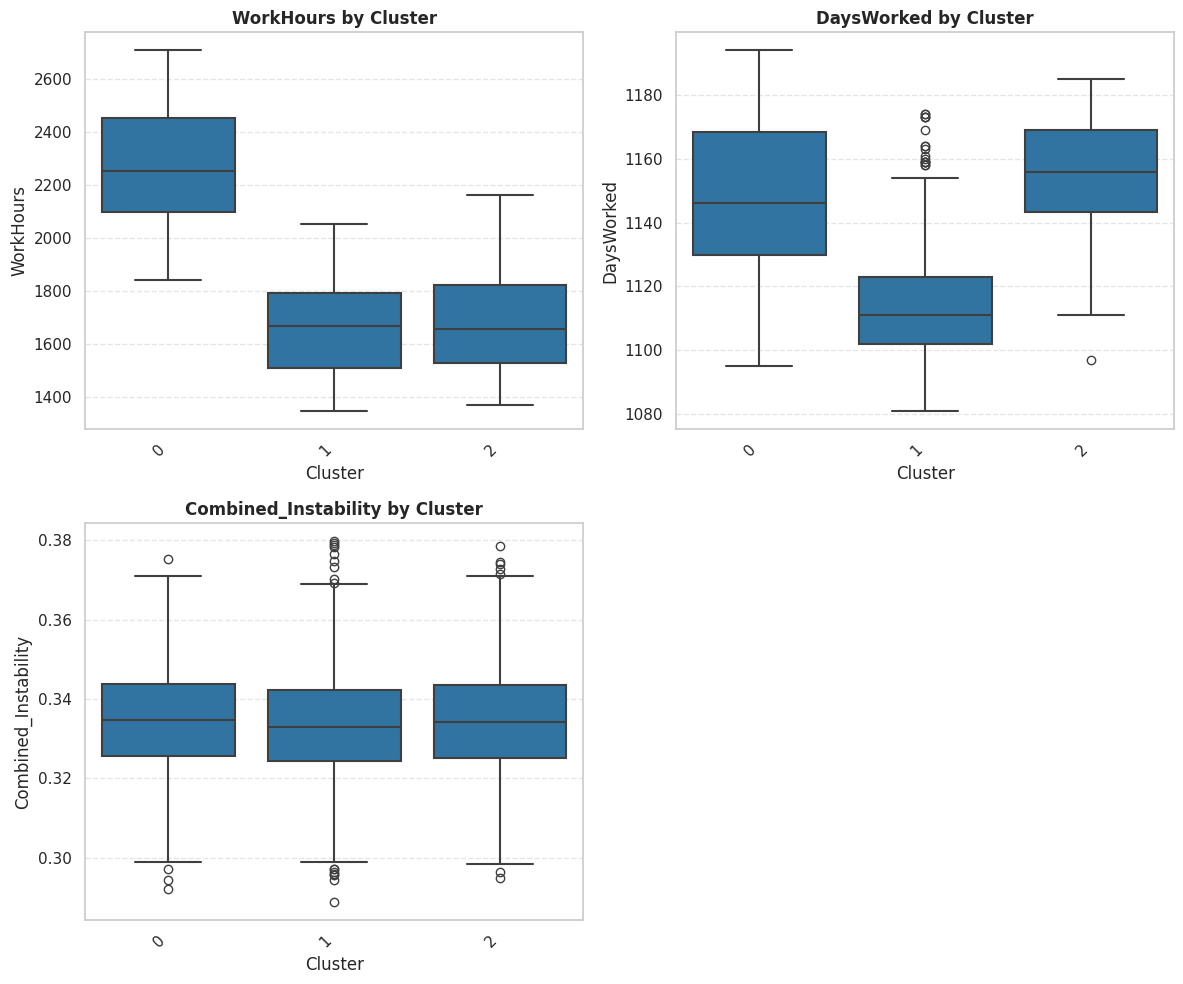

In [17]:
from visualization.explore_continuous import plot_box_grid

# Add KMeans labels to the validation DataFrame
kmeans_labels = models_results['KMeans'].named_steps['model'].labels_
validation_df['Cluster'] = kmeans_labels

# Display box plots for the numeric columns grouped by Cluster
plot_box_grid(
    validation_df, 
    value_cols=['WorkHours', 'DaysWorked', 'Combined_Instability'], 
    group_col='Cluster', 
    n_rows=2, 
    n_cols=2
)

The boxplots reveal clear differences between clusters across key continuous variables, highlighting distinct behavioral profiles. Cluster 0 stands out with the highest WorkHours, reflecting a very heavy workload, while Clusters 1 and 2 show lower, more moderate values.

DaysWorked separates clusters subtly: Cluster 0 maintains high attendance, Cluster 2 shows slightly higher upper ranges, and Cluster 1 has the lowest central values. Combined Instability overlaps across clusters, with Cluster 1 exhibiting marginally higher variability. Overall, these patterns highlight that workload and attendance are the main behavioral axes distinguishing the clusters.

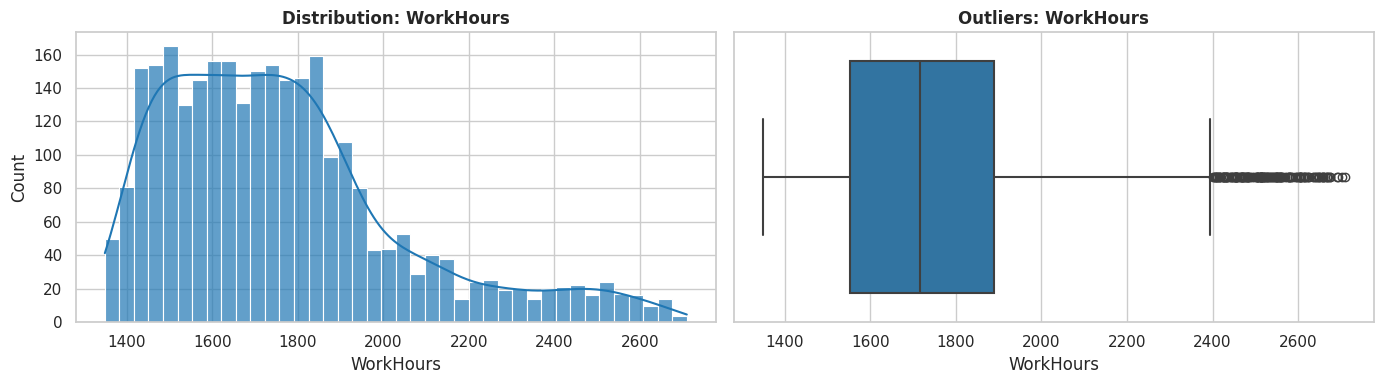

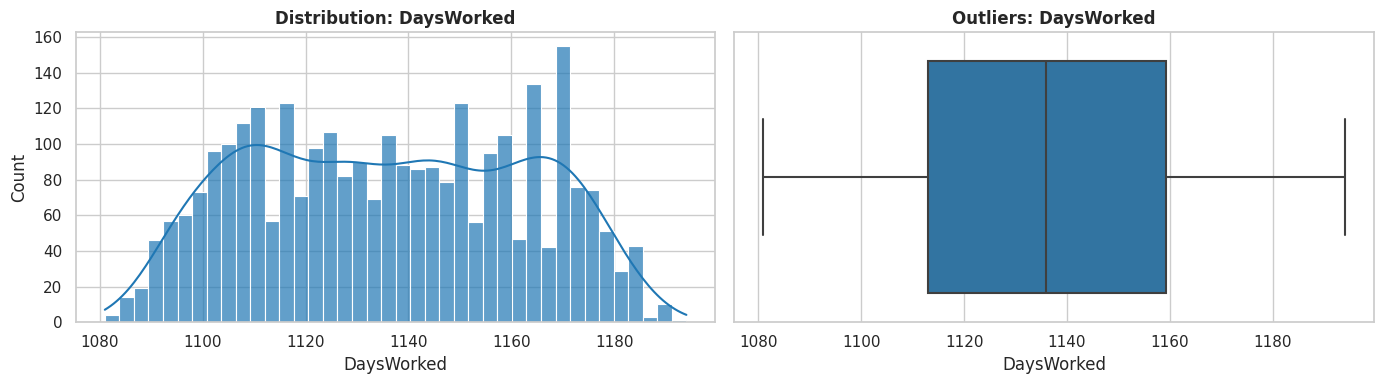

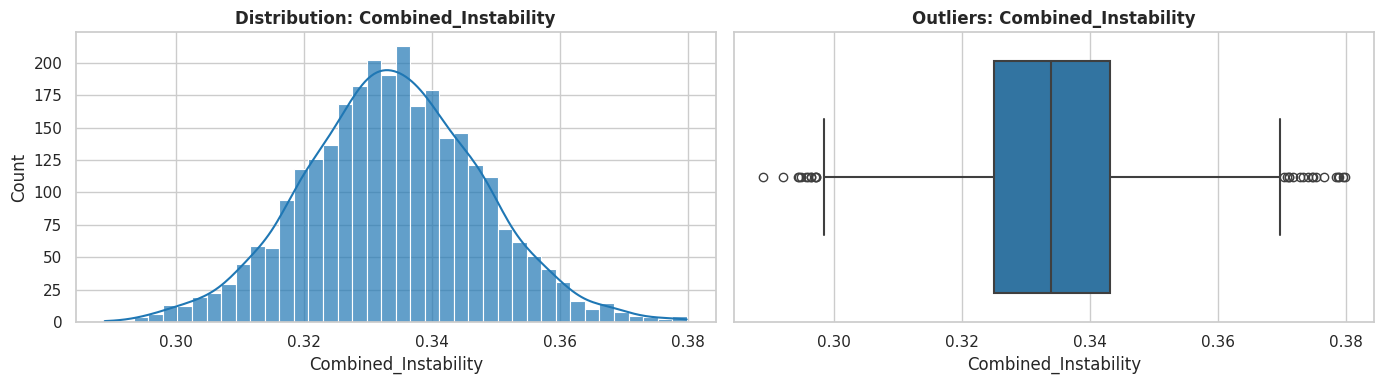

In [18]:
from visualization.explore_continuous import plot_numeric_distribution
plot_numeric_distribution(validation_df, ['WorkHours', 'DaysWorked', 'Combined_Instability'])

**Data Transformation**

In [19]:
from eda.best_transformation import best_transformation

#Select best data transformation 
print(best_transformation(validation_df['WorkHours']))
print(best_transformation(validation_df['DaysWorked']))

      Column Best Method  Original Skew  Transformed Skew
0  WorkHours      boxcox       1.089234           0.07022
       Column Best Method  Original Skew  Transformed Skew
0  DaysWorked  yeojohnson       0.030103          0.000043


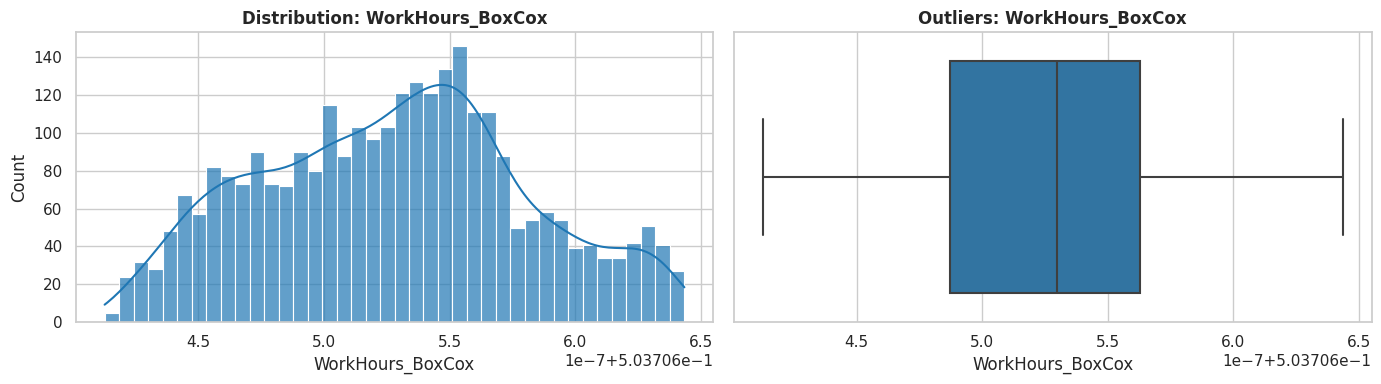

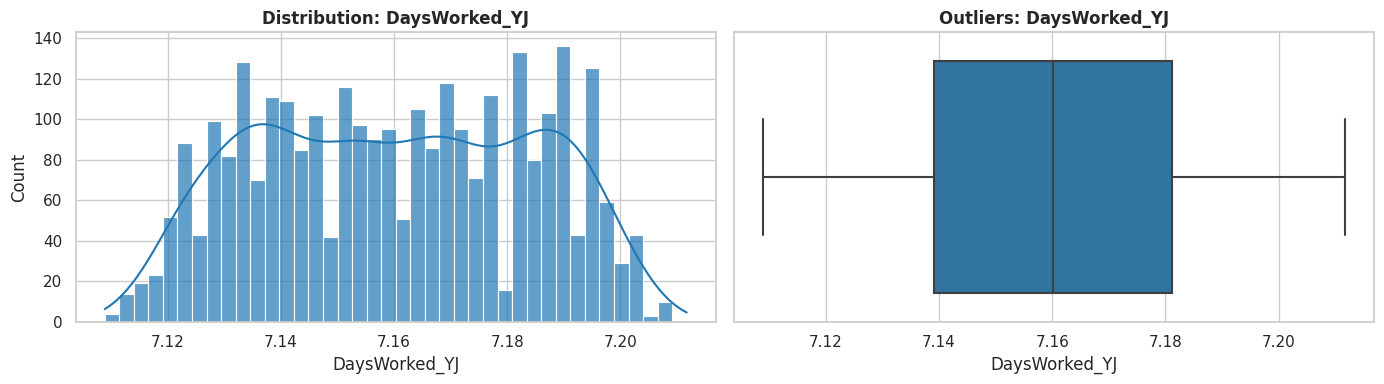

In [20]:
from scipy import stats

#Apply boxcox transformation and update
validation_df['WorkHours_BoxCox'], _ = stats.boxcox(validation_df['WorkHours'])
plot_numeric_distribution(validation_df, ['WorkHours_BoxCox'])  

#Apply yeojohnson transformation and update
validation_df['DaysWorked_YJ'], _ = stats.yeojohnson(validation_df['DaysWorked'])
plot_numeric_distribution(validation_df, ['DaysWorked_YJ'])

**Analysis of Variance and Evaluation**


 Complete Analysis: WorkHours_BoxCox

[1] Table ANOVA :


,sum_sq,df,F,PR(>F)
C(Cluster),3.590446e-12,2.0,1150.984408,0.0
Residual,4.499817e-12,2885.0,NaN,NaN



[2] Diagnostics :


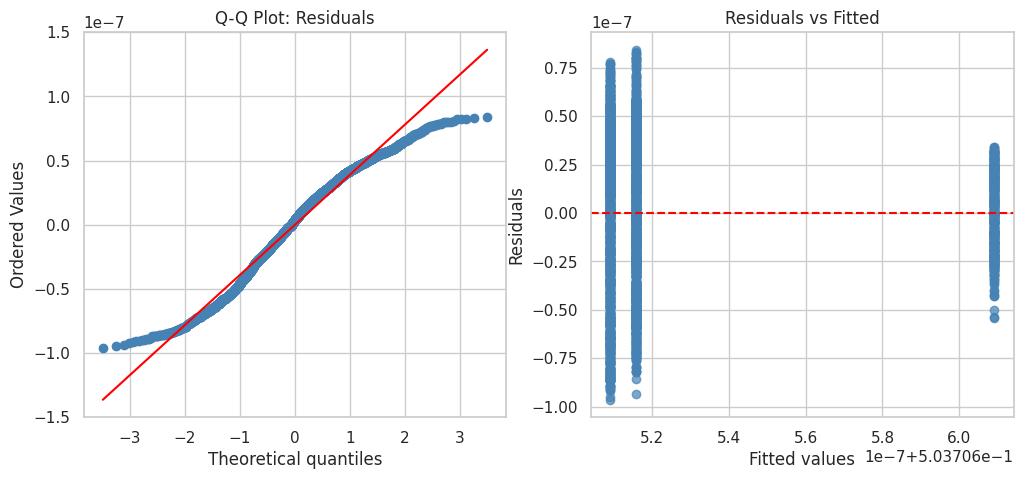

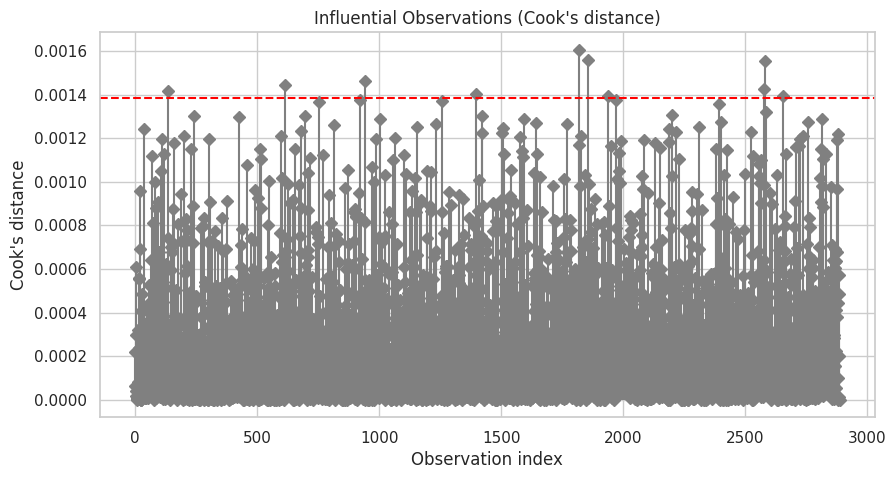

<Figure size 640x480 with 0 Axes>

=== Normality Tests (OLS only) ===


,Variable,Shapiro,Dagostino,Anderson,KS
0,Residuals,0.000000,0.000000,18.480600,0.000000



=== Variance Homogeneity / Heteroscedasticity Tests ===


,Levene,Bartlett
WorkHours_BoxCox,0.000000,0.000000



 Complete Analysis: DaysWorked_YJ

[1] Table ANOVA :


,sum_sq,df,F,PR(>F)
C(Cluster),0.940838,2.0,1868.752223,0.0
Residual,0.726238,2885.0,NaN,NaN



[2] Diagnostics :


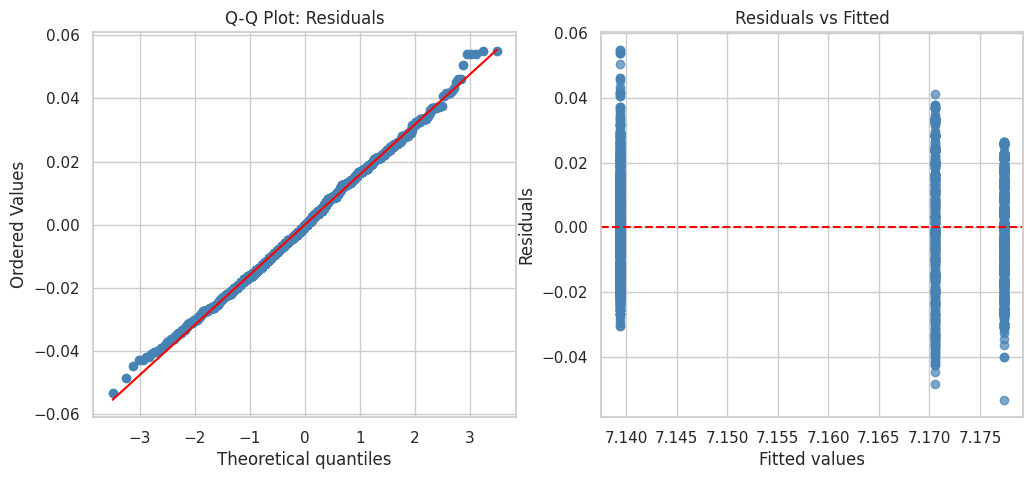

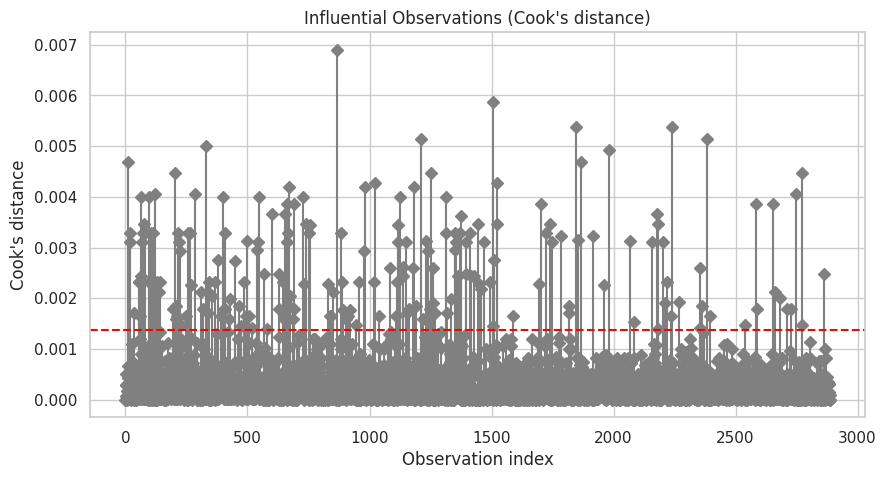

<Figure size 640x480 with 0 Axes>

=== Normality Tests (OLS only) ===


,Variable,Shapiro,Dagostino,Anderson,KS
0,Residuals,0.000400,0.015500,1.992300,0.005300



=== Variance Homogeneity / Heteroscedasticity Tests ===


,Levene,Bartlett
DaysWorked_YJ,0.000000,0.000000



 Complete Analysis: Combined_Instability

[1] Table ANOVA :


,sum_sq,df,F,PR(>F)
C(Cluster),0.000696,2.0,1.841173,0.158818
Residual,0.545494,2885.0,NaN,NaN



[2] Diagnostics :


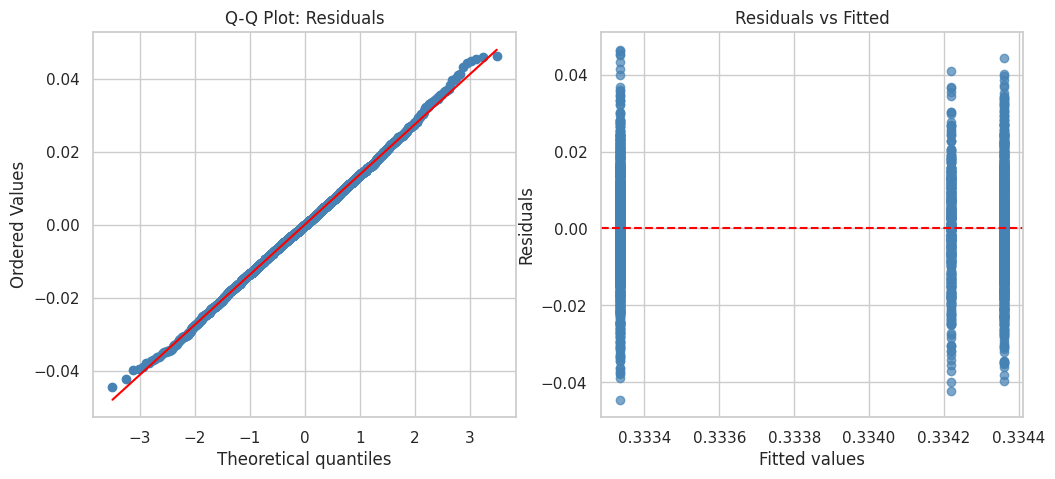

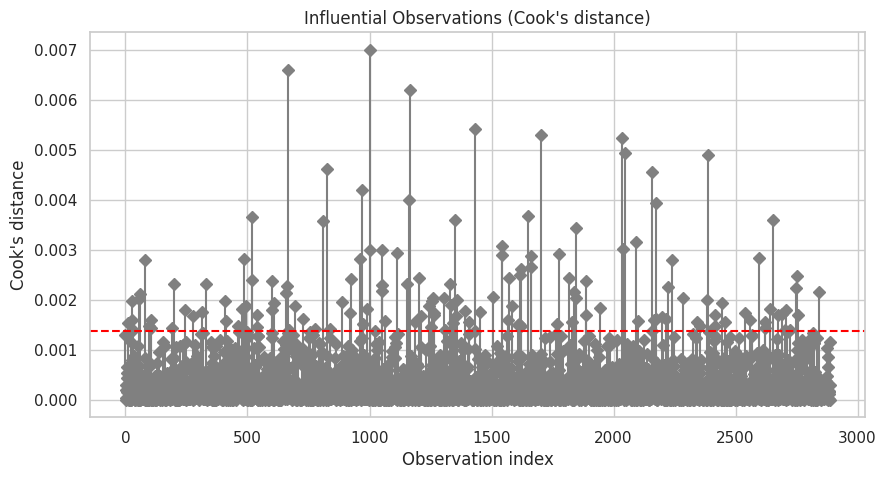

<Figure size 640x480 with 0 Axes>

=== Normality Tests (OLS only) ===


,Variable,Shapiro,Dagostino,Anderson,KS
0,Residuals,0.217900,0.227200,0.418100,0.838500



=== Variance Homogeneity / Heteroscedasticity Tests ===


,Levene,Bartlett
Combined_Instability,0.891000,0.816300


In [21]:
from eda.stats_param import anova_test
from eda.stats_diagnostics import stats_diagnostics

#List of columns to analyze
target_cols = ['WorkHours_BoxCox', 'DaysWorked_YJ', 'Combined_Instability']
group_var = 'Cluster'

for col in target_cols:
    print(f"\n" + "="*50)
    print(f" Complete Analysis: {col}")
    print("="*50)
    
    #Run the ANOVA and set return_model=True to pass the model to diagnostics
    table, model = anova_test(validation_df, col, group_var, return_model=True)
    
    #Display the ANOVA table
    print("\n[1] Table ANOVA :")
    display(table)
    
    #Run diagnostics (Plots, Normality tests, Heteroscedasticity)
    print("\n[2] Diagnostics :")
    stats_diagnostics(df=validation_df, 
                      numeric_cols=[col], 
                      group_col=group_var, 
                      model=model)

The complete ANOVA analyses reveal statistically significant differences between clusters for both WorkHours_BoxCox and DaysWorked_YJ, with extremely high F-values (F ≈ 1150 and 1869, respectively) and p-values effectively 0. This confirms that the clusters capture meaningful variation in workload and attendance metrics. For Combined_Instability, however, the ANOVA is not significant (F ≈ 1.84, p ≈ 0.16), suggesting no clear separation between clusters for this behavioral dimension.

Diagnostic checks indicate that residuals for WorkHours_BoxCox remain strongly non-normal and heteroscedastic despite the Box-Cox transformation. DaysWorked_YJ shows some improvement in normality, but variance homogeneity is still violated. Combined_Instability residuals are more acceptable, with no significant departures from normality or homoscedasticity.

Given these violations (particularly for WorkHours_BoxCox and DaysWorked_YJ) non-parametric confirmation is warranted. The Kruskal-Wallis test remains appropriate to robustly assess differences across clusters without relying on normality or equal variance assumptions, ensuring that the observed cluster effects on workload and attendance are statistically reliable.

**Kruskal-Wallis Test**

In [22]:
#Install required non-parametric statistical libraries
!pip install pingouin scikit-bio scikit-posthocs -q
from eda.stats_non_param import kruskal_wallis_test

#Specify target columns
k_target_cols = ['WorkHours_BoxCox', 'DaysWorked_YJ', 'Vol_Score']
for col in k_target_cols:
    print("\n" + "=" * 50)
    print(f" Complete Kruskal-Wallis Analysis: {col}")
    print("=" * 50)
    
    #Run the Kruskal-Wallis test
    stat, p_value = kruskal_wallis_test(
        df=validation_df,
        column=col,
        group=group_var
    )
    
    #Display results
    print(f"Kruskal-Wallis H = {stat:.4f}")
    print(f"p-value         = {p_value:.4g}")
    
    #Interpretation
    if p_value < 0.05:
        print("=> Significant differences between clusters")
    else:
        print("=> No significant differences between clusters")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 74.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 88.1 MB/s eta 0:00:00:00:0100:01

 Complete Kruskal-Wallis Analysis: WorkHours_BoxCox
Kruskal-Wallis test for WorkHours_BoxCox by Cluster
H-statistic = 1123.0302, p-value = 0.0000
Kruskal-Wallis H = 1123.0302
p-value         = 1.371e-244
=> Significant differences between clusters

 Complete Kruskal-Wallis Analysis: DaysWorked_YJ
Kruskal-Wallis test for DaysWorked_YJ by Cluster
H-statistic = 1642.6324, p-value = 0.0000
Kruskal-Wallis H = 1642.6324
p-value         = 0
=> Significant differences between clusters

 Complete Kruskal-Wallis Analysis: Vol_Score
Kruskal-Wallis test for Vol_Score by Cluster
H-statistic = 1828.8503, p-value = 0.0000
Kruskal-Wallis H = 1828.8503
p-value 

The Kruskal–Wallis tests confirm statistically significant differences between clusters for WorkHours_BoxCox (H = 1123.03, p ≈ 0), DaysWorked_YJ (H = 1642.63, p ≈ 0), and Vol_Score (H = 1828.85, p ≈ 0). The very large H-statistics indicate strong separation of distributions across clusters, consistent with the patterns observed in the boxplots. This is particularly relevant given the violations of normality and homogeneity of variance for WorkHours_BoxCox and DaysWorked_YJ.

By using a non-parametric approach, these results demonstrate that the identified clusters capture meaningful structural differences in employee behavior (including workload, attendance, and volatility) that are robust to distributional assumptions, reinforcing the substantive validity and interpretability of the K-Means solution.

## 2.5-Behavioral Archetypes

The clusters identified in this analysis are not intended as final descriptive typologies, but rather as structured targets to support the subsequent supervised classification phase developed in the following notebooks.

Clustering is used here as an intermediate step to uncover latent patterns in work intensity and instability, which are then formalized into discrete groups. These groups will serve as reference labels for training and evaluating classification models aimed at predicting attrition.

In [23]:
#Cluster information
cluster_summary = (
    validation_df
    .groupby('Cluster')[['WorkHours', 'DaysWorked', 'Combined_Instability', 'Vol_Score']]
    .agg(['mean', 'median'])
)

print(cluster_summary, "\n")

#Cluster distribution
cluster_counts = validation_df['Cluster'].value_counts().sort_index()
print(cluster_counts)

           WorkHours                DaysWorked         Combined_Instability  \
                mean       median         mean  median                 mean   
Cluster                                                                       
0        2278.430176  2252.958252  1147.665188  1146.0             0.334219   
1        1655.616943  1667.872803  1113.452785  1111.0             0.333334   
2        1682.349121  1656.100464  1155.156093  1156.0             0.334360   

                  Vol_Score         
           median      mean median  
Cluster                             
0        0.334819  3.055432    3.0  
1        0.332878  3.314770    3.0  
2        0.334157  1.448247    1.0   

Cluster
0     451
1    1239
2    1198
Name: count, dtype: int64


**Behavioral Cluster Archetypes Summary**

| Cluster | Archetype Name        | Workload (WorkHours) | Presence (DaysWorked) | Volatility (Vol_Score) | Behavioral Profile |
|--------:|----------------------|--------------------|----------------------|------------------------|-------------------|
| 0 | **Workhorses Elite** | Very High | High | High | Employees with exceptionally high workload and elevated volatility; highly engaged but at risk of overcommitment or burnout |
| 1 | **Quiet Disengaged** | Low | Low | High | Employees with lighter workload and high volatility; lower attendance reflects early signs of disengagement |
| 2 | **Balanced Contributors** | Moderate | High | Low | Employees with moderate workload and attendance; volatility is low, reflecting stable but flexible engagement patterns |

---

**Notes / Interpretation**

- **Instability / Combined_Instability** differences are minimal across clusters and do not contribute meaningfully to separation.  
- **Vol_Score** now highlights the main behavioral axis of volatility, clearly distinguishing high-load, high-volatility employees (Cluster 0) from more stable clusters (1 and 2).  
- These archetypes summarize **behavioral patterns**, not performance levels, and provide structured features for predictive modeling (e.g., attrition risk, workload management).


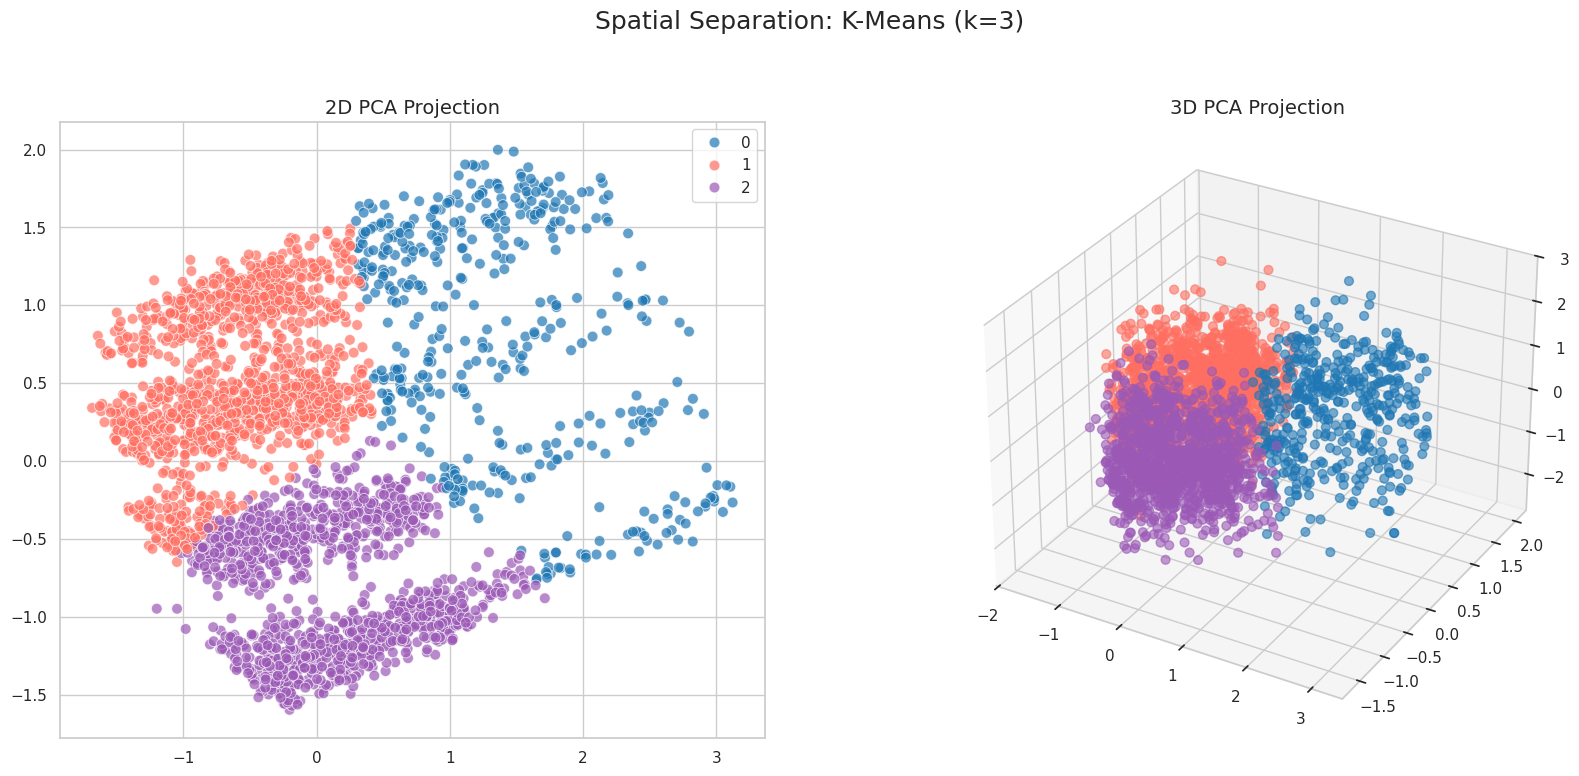

In [24]:
from visualization.explore_clusters import plot_cluster_projections

# Label extraction
kmeans_labels = models_results['KMeans'].named_steps['model'].labels_

# Display
plot_cluster_projections(df_scaled[final_numeric_cols], kmeans_labels, model_name="K-Means (k=3)")


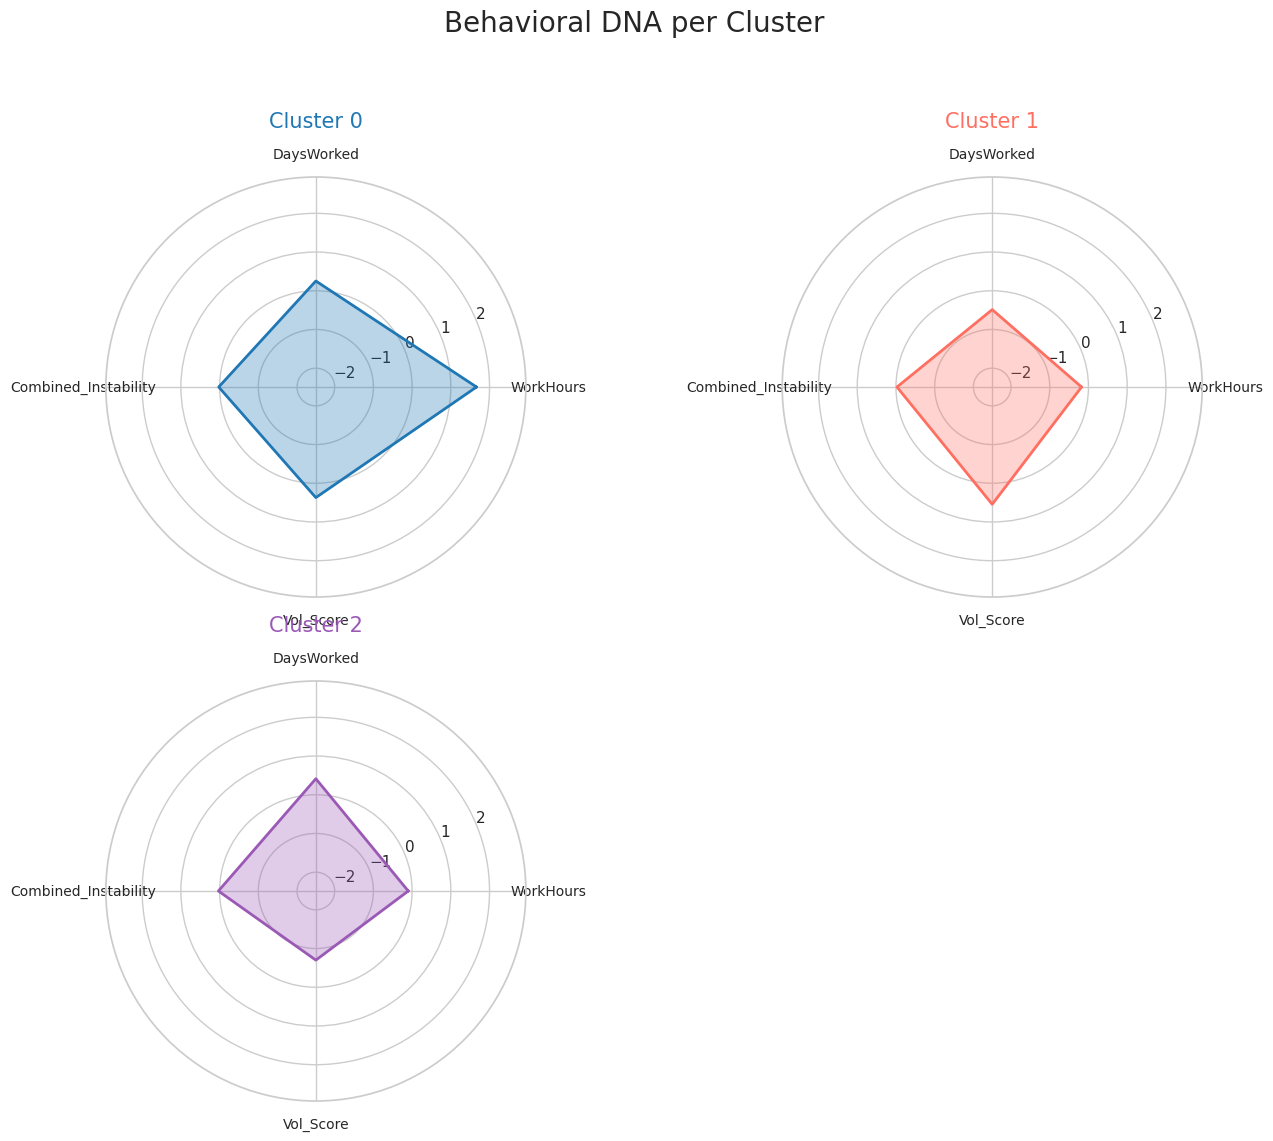

In [25]:
from visualization.explore_clusters import plot_cluster_radar_charts
plot_cluster_radar_charts(df_scaled, kmeans_labels, final_numeric_cols)

## 2.6-Summary - Notebook 2

| Category               | Main Implementation            | Notes / Insights |
|------------------------|-------------------------------|-----------------|
| Data Refining          | High-Fidelity Aggregation      | 1.1M logs aggregated back into the original 4,410 unique employee profiles. Shifted from raw daily hours to cumulative behavioral pillars (Workload, Presence, Instability). |
| Feature Engineering    | Instability Index              | Reconstructed Combined_Instability by merging arrival and departure variance. Though differences across clusters are minimal, Vol_Score captures key behavioral volatility. |
| Outlier Strategy       | Robust Scaling                 | Opted for RobustScaler (IQR-based) instead of pruning. Preserved extreme engagement profiles (High-Workload) which are critical for future attrition detection. |
| Model Selection        | K-Means vs. Others             | Evaluated 5 algorithms (GMM, BIRCH, DBSCAN, etc.). K-Means outperformed in cohesion and separation for these smooth behavioral distributions. |
| Structural Validation  | Algorithmic Stability          | Used ARI across multiple seeds and subsampling. Confirmed a Highly Stable structure ensuring clusters are real patterns. |
| Statistical Rigor      | Non-Parametric Testing         | Moved from ANOVA to Kruskal-Wallis ($p < 0.001$). Robustly confirmed that clusters represent statistically distinct populations across all behavioral dimensions (Workload, Attendance, Volatility). |
| Final Archetypes       | Behavioral Mapping             | Identified 3 distinct personas: Workhorses Elite (High Workload, High Volatility), Quiet Disengaged (Low Workload, High Volatility), and Balanced Contributors (Moderate Workload, Low Volatility). |


## 2.7-Data Export

In [26]:
import pickle

# Mapping cluster number → archetype name (3 clusters)
cluster_names = {
    0: "Workhorse Elite",
    1: "Quiet Disengaged",
    2: "Balanced Contributor"
}

# Create the dataset
employee_archetypes = validation_df[['EmployeeID', 'Cluster']].copy()
employee_archetypes['Archetype'] = employee_archetypes['Cluster'].map(cluster_names)
employee_archetypes = employee_archetypes[['EmployeeID', 'Archetype']]

# Quick check
print(employee_archetypes.head(), "\n")

# Export as pickle
output_filename = "/kaggle/working/employee_archetypes.pkl"
with open(output_filename, "wb") as f:
    pickle.dump(employee_archetypes, f)

print(f"Dataset exported successfully: {output_filename}", "\n")
print("Dataset shape:", employee_archetypes.shape)


   EmployeeID             Archetype
0           1      Quiet Disengaged
1           2  Balanced Contributor
2           3  Balanced Contributor
3           4      Quiet Disengaged
4           5  Balanced Contributor 

Dataset exported successfully: /kaggle/working/employee_archetypes.pkl 

Dataset shape: (2888, 2)
